In [ ]:
import os
import time
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm  # Use tqdm.notebook for better Jupyter integration

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# Make sure you have these installed:
# pip install pytorch-metric-learning scikit-learn deeplake
from pytorch_metric_learning import losses, miners
import deeplake

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Check for GPU
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Experiment Parameters ---
# We are now using the full dataset, so these are no longer needed
# NUM_TRAIN_SAMPLES = 1000
# NUM_TEST_SAMPLES = 200
TEST_SPLIT_RATIO = 0.2 # Use 20% of the data for testing

BATCH_SIZE = 32
IMAGE_SIZE = 128
# Let's reduce epochs for a faster full run, or keep it if you have time
NUM_EPOCHS = 50
EMBEDDING_DIM = 64
LEARNING_RATE = 0.0001
NUM_WORKERS = 0 # Keep at 0 for stability on CPU

# --- PATHS (These should be correct) ---
DEEPLAKE_PATH = './dl_datasets/shdataset_12k'
LOCAL_PNG_ROOT = './db/SHdataset_12k' 

In [3]:
print("--- Step 3 (Full Dataset): Creating canonical file order ---")

def safe_get_tensor_item_value(tensor_item):
    """Safely extracts a Python native value from a single item from a Deep Lake tensor."""
    if hasattr(tensor_item, 'text') and callable(tensor_item.text): return tensor_item.text()
    if isinstance(tensor_item, (str, int, float)): return tensor_item
    if hasattr(tensor_item, 'numpy') and callable(tensor_item.numpy):
        np_val = tensor_item.numpy()
        if np_val.size == 1: return np_val.item() if np_val.ndim == 0 else np_val[0]
        return np_val 
    if isinstance(tensor_item, np.ndarray):
        if tensor_item.size == 1: return tensor_item.item() if tensor_item.ndim == 0 else tensor_item[0]
        return tensor_item
    try: return str(tensor_item)
    except Exception: return "ErrorConvertingItem"

# 1. Load the dataset using deeplake.open()
ds = deeplake.open(DEEPLAKE_PATH)

# 2. Manually iterate to get all filenames from the 'train' split
print("Manually iterating to get all 'train' filenames...")
filenames_list = []
for i in tqdm(range(len(ds)), desc="Manually filtering"):
    if safe_get_tensor_item_value(ds[i]['split']) == 'train':
        filenames_list.append(safe_get_tensor_item_value(ds[i]['original_filename']))

# 3. Sort the extracted list to have a canonical order
all_filenames = sorted(filenames_list)
print(f"\nFound and sorted {len(all_filenames)} total filenames in the 'train' split.")

# 4. Dynamically create train/test splits from the full list
num_total_files = len(all_filenames)
num_test_files = int(num_total_files * TEST_SPLIT_RATIO)
num_train_files = num_total_files - num_test_files

train_filenames = all_filenames[:num_train_files]
test_filenames = all_filenames[num_train_files:]

print(f"Splitting into {len(train_filenames)} training samples and {len(test_filenames)} testing samples.")

--- Step 3 (Full Dataset): Creating canonical file order ---
Manually iterating to get all 'train' filenames...


Manually filtering:   0%|          | 0/12051 [00:00<?, ?it/s]


Found and sorted 9641 total filenames in the 'train' split.
Splitting into 7713 training samples and 1928 testing samples.


In [4]:
# --- Cell 4: Define Shared Components (Corrected) ---

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super(EmbeddingNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, embedding_dim)
    def forward(self, x):
        return self.resnet(x)

# FINAL CORRECTED VERSION of evaluate_model
def evaluate_model(model, train_loader_for_eval, test_loader, device):
    """
    Evaluates the model and returns a dictionary with metrics, the trained k-NN,
    and the embeddings/labels used for visualization.
    """
    print("\n--- Starting Evaluation ---")
    model.eval()
    
    # Generate embeddings for the training set (to train the k-NN)
    train_embeddings, train_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(train_loader_for_eval, desc="Generating train embeddings"):
            embeddings = model(images.to(device))
            train_embeddings.append(embeddings.cpu().numpy())
            train_labels.append(labels.numpy())
    train_embeddings = np.concatenate(train_embeddings)
    train_labels = np.concatenate(train_labels)

    # Generate embeddings for the test set (to evaluate the k-NN)
    test_embeddings, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Generating test embeddings"):
            embeddings = model(images.to(device))
            test_embeddings.append(embeddings.cpu().numpy())
            test_labels.append(labels.numpy())
    test_embeddings = np.concatenate(test_embeddings)
    test_labels = np.concatenate(test_labels)

    # Train k-NN and predict
    print("Training k-NN classifier on learned embeddings...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_embeddings, train_labels)
    predictions = knn.predict(test_embeddings)
    pred_probs = knn.predict_proba(test_embeddings)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    auc = roc_auc_score(test_labels, pred_probs)
    
    print("--- Evaluation Complete ---")
    
    # This is the correct return dictionary that matches what our pipelines expect
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "auc": auc,
        "knn_classifier": knn,
        "test_embeddings": test_embeddings,
        "test_labels": test_labels
    }

In [5]:
# --- Pipeline A: Local PNG Files (Corrected Return Statement) ---

class LocalPNGDataset(Dataset):
    # ... (The class definition is correct and does not need to change) ...
    def __init__(self, root_dir, filenames, image_size, split='train'):
        self.root_dir = root_dir
        self.filenames = filenames
        self.split = split
        self.image_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.root_dir, self.split, 'images', filename)
        mask_path = os.path.join(self.root_dir, self.split, 'masks', filename)
        if not os.path.exists(image_path): raise FileNotFoundError(f"Image not found at: {image_path}")
        if not os.path.exists(mask_path): raise FileNotFoundError(f"Mask not found at: {mask_path}")
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)
        label = 1 if np.any(np.array(mask) > 0) else 0
        return self.image_transform(image), torch.tensor(label, dtype=torch.long)

def run_pipeline_local_files(train_filenames, test_filenames):
    # ... (The setup and training loop are correct and do not need to change) ...
    print("\n" + "="*60)
    print("  RUNNING PIPELINE: Local PNG Files")
    print("="*60)
    train_dataset = LocalPNGDataset(LOCAL_PNG_ROOT, train_filenames, IMAGE_SIZE, split='train')
    test_dataset = LocalPNGDataset(LOCAL_PNG_ROOT, test_filenames, IMAGE_SIZE, split='train')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    train_loader_for_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    model = EmbeddingNet().to(device)
    loss_func = losses.TripletMarginLoss(margin=0.2)
    miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("\n--- Starting DML Training ---")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        model.train()
        pbar = tqdm(train_loader, desc=f"Local Files - Epoch {epoch+1}/{NUM_EPOCHS}")
        for images, labels in pbar:
            optimizer.zero_grad()
            embeddings = model(images.to(device))
            hard_triplets = miner(embeddings, labels.to(device))
            loss = loss_func(embeddings, labels.to(device), hard_triplets)
            if loss is not None:
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=f"{loss.item():.4f}")
    training_duration = time.time() - start_time
    print(f"--- Training Complete [Duration: {training_duration:.2f}s] ---")
    
    # Run the evaluation
    eval_results = evaluate_model(model, train_loader_for_eval, test_loader, device)
    
    # --- THE FIX IS HERE ---
    # We now correctly construct the nested dictionary that the final report expects.
    return {
        "time": training_duration,
        "metrics": {
            "accuracy": eval_results["accuracy"],
            "f1_score": eval_results["f1_score"],
            "auc": eval_results["auc"]
        },
        "model": model, 
        "knn": eval_results["knn_classifier"],
        "embeddings": eval_results["test_embeddings"],
        "labels": eval_results["test_labels"]
    }

In [6]:
# --- Pipeline B: Deep Lake (Corrected Return Statement) ---

class DeeplakeSequentialDataset(Dataset):
    # ... (The class definition is correct and does not need to change) ...
    def __init__(self, ds_object, list_of_indices, image_size):
        self.ds = ds_object
        self.indices = list_of_indices
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        actual_ds_index = self.indices[idx]
        sample = self.ds[actual_ds_index]
        image_np = sample["images"]
        mask_np = sample["masks"]
        if not isinstance(image_np, np.ndarray): raise TypeError(f"Expected image to be a numpy array, but got {type(image_np)}")
        image = Image.fromarray(image_np).convert('RGB')
        label = 1 if np.any(mask_np > 0) else 0
        return self.transform(image), torch.tensor(label, dtype=torch.long)


def run_pipeline_deeplake(train_indices, test_indices):
    # ... (The setup and training loop are correct and do not need to change) ...
    print("\n" + "="*60)
    print("  RUNNING PIPELINE: Deep Lake (Sequential Access)")
    print("="*60)
    ds = deeplake.open(DEEPLAKE_PATH)
    print("Finding all 'train' sample indices in the full dataset...")
    all_train_indices_in_ds = [i for i, s in enumerate(ds['split']) if safe_get_tensor_item_value(s) == 'train']
    train_indices_subset = [all_train_indices_in_ds[i] for i in train_indices]
    test_indices_subset = [all_train_indices_in_ds[i] for i in test_indices]
    train_dataset = DeeplakeSequentialDataset(ds, train_indices_subset, IMAGE_SIZE)
    test_dataset = DeeplakeSequentialDataset(ds, test_indices_subset, IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    train_loader_for_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    model = EmbeddingNet().to(device)
    loss_func = losses.TripletMarginLoss(margin=0.2)
    miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("\n--- Starting DML Training ---")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        model.train()
        pbar = tqdm(train_loader, desc=f"Deep Lake - Epoch {epoch+1}/{NUM_EPOCHS}")
        for images, labels in pbar:
            optimizer.zero_grad()
            embeddings = model(images.to(device))
            hard_triplets = miner(embeddings, labels.to(device))
            loss = loss_func(embeddings, labels.to(device), hard_triplets)
            if loss is not None:
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=f"{loss.item():.4f}")
    training_duration = time.time() - start_time
    print(f"--- Training Complete [Duration: {training_duration:.2f}s] ---")
    
    eval_results = evaluate_model(model, train_loader_for_eval, test_loader, device)

    # --- THE FIX IS HERE ---
    # We now correctly construct the nested dictionary that the final report expects.
    return {
        "time": training_duration,
        "metrics": {
            "accuracy": eval_results["accuracy"],
            "f1_score": eval_results["f1_score"],
            "auc": eval_results["auc"]
        },
        "model": model, 
        "knn": eval_results["knn_classifier"],
        "embeddings": eval_results["test_embeddings"],
        "labels": eval_results["test_labels"]
    }

In [8]:
# --- The Final Execution (Corrected) ---

print("--- Starting Full Experiment ---")

# --- Final Setup for Pair-to-Pair Comparison ---

# 1. We already have 'train_filenames' and 'test_filenames' from Cell 3.
#    These are correct and will be passed to the Local PNG pipeline.

# 2. For the Deep Lake pipeline, we need a list of RELATIVE indices that correspond
#    to the filenames. This ensures the test set is separate.
num_train = len(train_filenames)
num_test = len(test_filenames)
all_relative_indices = list(range(num_train + num_test))

# CORRECT: The test indices start where the train indices stop.
train_indices_for_deeplake = all_relative_indices[:num_train]  # Will be [0, 1, ..., 999]
test_indices_for_deeplake = all_relative_indices[num_train:]   # Will be [1000, 1001, ..., 1199]

print("Index setup complete. Train and test sets are now guaranteed to be separate.")
print(f"Deep Lake will use relative indices {train_indices_for_deeplake[0]}-{train_indices_for_deeplake[-1]} for training.")
print(f"Deep Lake will use relative indices {test_indices_for_deeplake[0]}-{test_indices_for_deeplake[-1]} for testing.")


# --- Run the Pipelines ---

# Run the pipeline for Local PNG files using the filename lists
local_results = run_pipeline_local_files(train_filenames, test_filenames)

# Run the pipeline for Deep Lake using the correctly partitioned index lists
deeplake_results = run_pipeline_deeplake(train_indices_for_deeplake, test_indices_for_deeplake)


# --- Final Comparison Report ---
print("\n\n" + "#"*60)
print("##                  FINAL BENCHMARK RESULTS                  ##")
print("#"*60)
print(f"\nConfiguration: {len(train_filenames)} train, {len(test_filenames)} test, {NUM_EPOCHS} epochs.")
print(f"Device: {device}, Num Workers: {NUM_WORKERS}")

print("\n--- PERFORMANCE (TRAINING SPEED) ---")
print(f"  - Local PNG Files : {local_results['time']:.2f} seconds")
print(f"  - Deep Lake       : {deeplake_results['time']:.2f} seconds")

if deeplake_results['time'] > 0 and local_results['time'] > 0:
    if local_results['time'] < deeplake_results['time']:
        speedup = deeplake_results['time'] / local_results['time']
        print(f"  --> Local PNGs were {speedup:.2f}x faster.")
    else:
        speedup = local_results['time'] / deeplake_results['time']
        print(f"  --> Deep Lake was {speedup:.2f}x faster.")

print("\n--- EFFECTIVENESS (k-NN on Embeddings) ---")
print("                     | Local Files | Deep Lake")
print("---------------------|-------------|-----------")
print(f" Accuracy            | {local_results['metrics']['accuracy']:.4f}      | {deeplake_results['metrics']['accuracy']:.4f}")
print(f" F1-Score            | {local_results['metrics']['f1_score']:.4f}      | {deeplake_results['metrics']['f1_score']:.4f}")
print(f" AUC Score           | {local_results['metrics']['auc']:.4f}      | {deeplake_results['metrics']['auc']:.4f}")
print("\n" + "#"*60)

--- Starting Full Experiment ---
Index setup complete. Train and test sets are now guaranteed to be separate.
Deep Lake will use relative indices 0-7712 for training.
Deep Lake will use relative indices 7713-9640 for testing.

  RUNNING PIPELINE: Local PNG Files

--- Starting DML Training ---


Local Files - Epoch 1/50:   0%|          | 0/242 [00:00<?, ?it/s]

AcceleratorError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# --- Cell 8: Define the Single Image Prediction Function ---

def predict_single_image(model, knn, image_path, device, image_size):
    """Loads a single image, gets its embedding, and classifies it with the k-NN."""
    
    # Define the same transformations used during training
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform the image
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"ERROR: Image not found at {image_path}")
        return

    # The model expects a batch, so we add a "batch" dimension of 1
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get the embedding
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        embedding = model(image_tensor).cpu().numpy()
        
    # Get the prediction from the k-NN
    prediction = knn.predict(embedding)[0]
    prediction_prob = knn.predict_proba(embedding)[0]
    
    # Map prediction to human-readable format
    class_map = {0: "No Egg", 1: "Egg"}
    predicted_class = class_map[prediction]
    
    print(f"\n--- Prediction for: {os.path.basename(image_path)} ---")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence (Probability of being 'Egg'): {prediction_prob[1]:.2%}")

print("Prediction function `predict_single_image` is now defined.")

Prediction function `predict_single_image` is now defined.


In [ ]:
# --- Cell 9: Side-by-Side Inference Comparison ---

# Use the prediction function defined in Cell 8
# predict_single_image(model, knn, image_path, device, image_size)

# Pick a single image to test
test_image_path = os.path.join(LOCAL_PNG_ROOT, 'train', 'images', test_filenames[50]) # Pick the 51st test image

print("\n" + "#"*60)
print("##                 INFERENCE COMPARISON                  ##")
print("#"*60)

# --- Prediction using the PNG-trained model ---
print("\n--- Using Model Trained on Local PNGs ---")
predict_single_image(
    local_results['model'], 
    local_results['knn'], 
    test_image_path, 
    device, 
    IMAGE_SIZE
)

# --- Prediction using the Deep Lake-trained model ---
print("\n--- Using Model Trained on Deep Lake ---")
predict_single_image(
    deeplake_results['model'], 
    deeplake_results['knn'], 
    test_image_path, 
    device, 
    IMAGE_SIZE
)


############################################################
##                 INFERENCE COMPARISON                  ##
############################################################

--- Using Model Trained on Local PNGs ---

--- Prediction for: 6259.png ---
Predicted Class: No Egg
Confidence (Probability of being 'Egg'): 0.00%

--- Using Model Trained on Deep Lake ---

--- Prediction for: 6259.png ---
Predicted Class: No Egg
Confidence (Probability of being 'Egg'): 0.00%


NameError: name 'local_results' is not defined

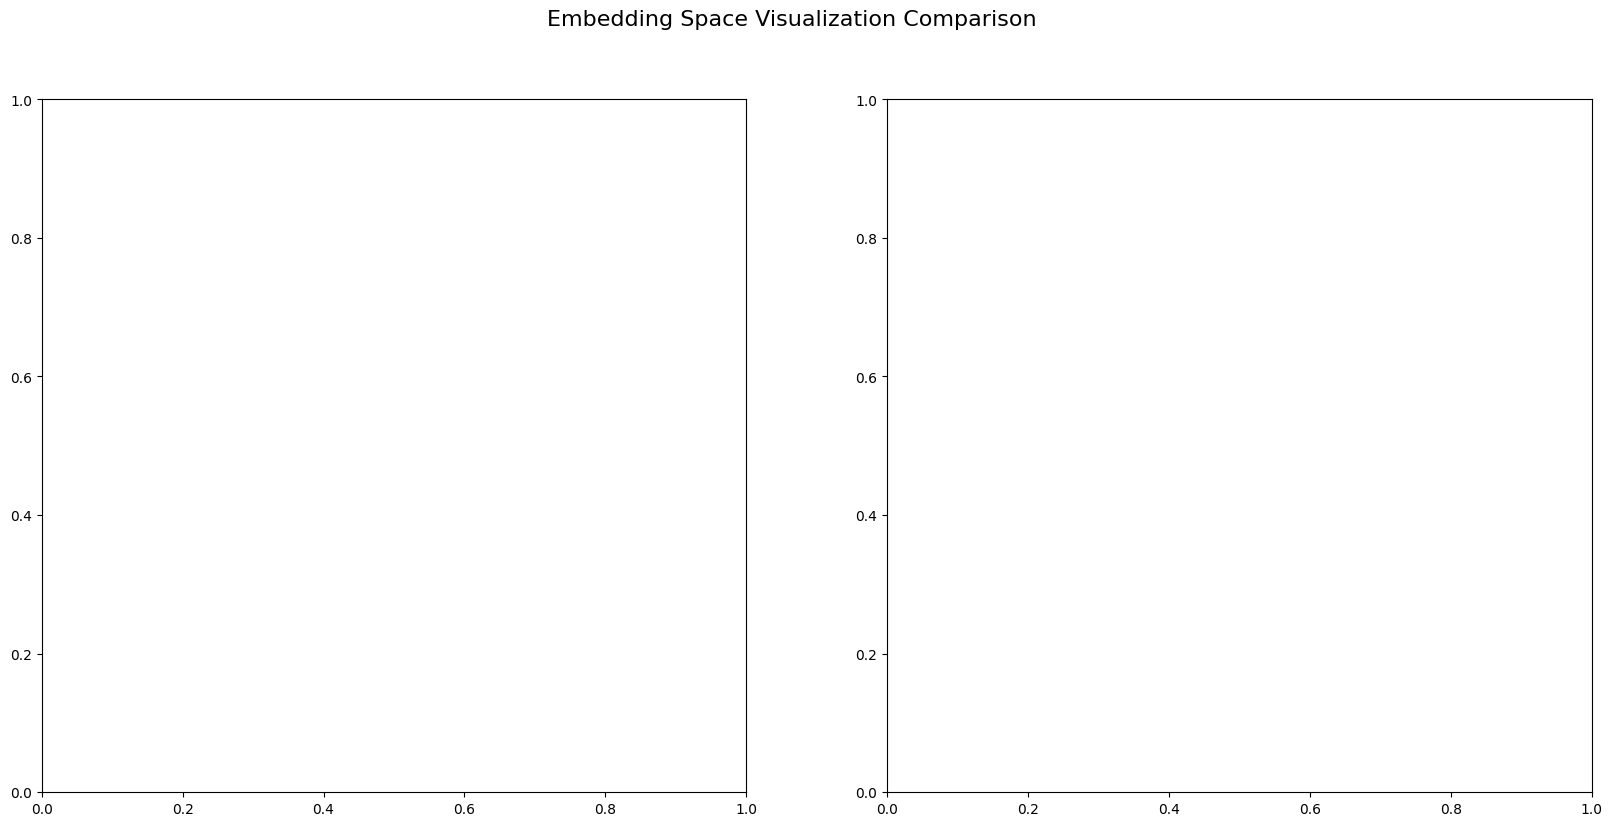

In [ ]:
# --- Cell 10: Side-by-Side Visualization Comparison (Corrected) ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def create_tsne_plot(ax, embeddings, labels, title):
    """Helper function to create one t-SNE plot on a given matplotlib axis."""
    print(f"--- Running t-SNE for '{title}' ---")
    
    # --- THE FIX IS HERE ---
    # In modern scikit-learn, 'n_iter' is replaced by 'max_iter'.
    # We also specify 'init' and 'learning_rate' which are good defaults.
    tsne = TSNE(
        n_components=2, 
        perplexity=30, 
        init='pca', 
        max_iter=1000, # Use max_iter instead of n_iter
        learning_rate='auto',
        n_jobs=-1 # Use all available CPU cores to speed up t-SNE
    )
    # -----------------------
    
    embeddings_2d = tsne.fit_transform(embeddings)
    
    class_map = {0: "No Egg", 1: "Egg"}
    colors = {0: 'blue', 1: 'red'}
    
    for class_id, class_name in class_map.items():
        indices = np.where(labels == class_id)
        ax.scatter(
            embeddings_2d[indices, 0], 
            embeddings_2d[indices, 1], 
            c=colors[class_id],
            label=class_name,
            alpha=0.7
        )
    ax.set_title(title)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend()
    ax.grid(True)

# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Embedding Space Visualization Comparison', fontsize=16)

# --- Plot for the PNG-trained model ---
create_tsne_plot(
    ax1, 
    local_results['embeddings'], 
    local_results['labels'], 
    title="Trained on Local PNGs"
)

# --- Plot for the Deep Lake-trained model ---
create_tsne_plot(
    ax2, 
    deeplake_results['embeddings'], 
    deeplake_results['labels'], 
    title="Trained on Deep Lake"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import pandas as pd
import os

print("\n" + "#"*60)
print("##                     SAVING FINAL RESULTS                     ##")
print("#"*60)

# --- 1. Create a Directory for the Results ---
output_dir = "experiment_results"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in the '{output_dir}' directory.")


# --- 2. Save the Final Metrics to a CSV File ---

# First, let's create a flat dictionary for easier DataFrame creation
summary_data = {
    'Pipeline': ['Local PNGs', 'Deep Lake'],
    'Training Time (s)': [local_results['time'], deeplake_results['time']],
    'Accuracy': [local_results['metrics']['accuracy'], deeplake_results['metrics']['accuracy']],
    'F1-Score': [local_results['metrics']['f1_score'], deeplake_results['metrics']['f1_score']],
    'AUC Score': [local_results['metrics']['auc'], deeplake_results['metrics']['auc']]
}

# Convert to a pandas DataFrame for easy saving
summary_df = pd.DataFrame(summary_data)

# Define the path and save the CSV
csv_path = os.path.join(output_dir, "final_comparison_metrics.csv")
summary_df.to_csv(csv_path, index=False, float_format='%.4f')

print(f"\nFinal metrics successfully saved to: {csv_path}")
print("\n--- Content of CSV File ---")
print(summary_df.to_string(index=False))


# --- 3. Save the Trained Models (State Dictionaries) ---
# Saving the model's 'state_dict' is the recommended PyTorch way.
# It's just the learned weights, not the entire model structure.

# Save the model trained on PNGs
local_model_path = os.path.join(output_dir, "model_trained_on_pngs.pth")
torch.save(local_results['model'].state_dict(), local_model_path)
print(f"\nModel trained on PNGs saved to: {local_model_path}")

# Save the model trained on Deep Lake
deeplake_model_path = os.path.join(output_dir, "model_trained_on_deeplake.pth")
torch.save(deeplake_results['model'].state_dict(), deeplake_model_path)
print(f"Model trained on Deep Lake saved to: {deeplake_model_path}")


# --- 4. (Optional) Save Embeddings for Later Visualization ---
# This is useful if you want to re-create the t-SNE plots without retraining.
local_embeddings_path = os.path.join(output_dir, "embeddings_from_png_model.npz")
np.savez(local_embeddings_path, embeddings=local_results['embeddings'], labels=local_results['labels'])
print(f"\nEmbeddings from PNG model saved to: {local_embeddings_path}")

deeplake_embeddings_path = os.path.join(output_dir, "embeddings_from_deeplake_model.npz")
np.savez(deeplake_embeddings_path, embeddings=deeplake_results['embeddings'], labels=deeplake_results['labels'])
print(f"Embeddings from Deep Lake model saved to: {deeplake_embeddings_path}")

print("\n" + "#"*60)
print("##                      SAVE COMPLETE                      ##")
print("#"*60)


############################################################
##                     SAVING FINAL RESULTS                     ##
############################################################
Results will be saved in the 'experiment_results' directory.

Final metrics successfully saved to: experiment_results/final_comparison_metrics.csv

--- Content of CSV File ---
  Pipeline  Training Time (s)  Accuracy  F1-Score  AUC Score
Local PNGs       17469.215718  0.847510  0.563798   0.772518
 Deep Lake       21140.231081  0.833506  0.545969   0.771607

Model trained on PNGs saved to: experiment_results/model_trained_on_pngs.pth
Model trained on Deep Lake saved to: experiment_results/model_trained_on_deeplake.pth

Embeddings from PNG model saved to: experiment_results/embeddings_from_png_model.npz
Embeddings from Deep Lake model saved to: experiment_results/embeddings_from_deeplake_model.npz

############################################################
##                      SAVE COMPLETE      